In [282]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [283]:
def resize_image(img, new_size=(256, 256)):
    return cv.resize(img, new_size)

In [284]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (256, 256))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [285]:
images, filenames, labels, path, distribusi = insertGambar("Dataset2/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne Vulgaris


100%|██████████| 100/100 [00:02<00:00, 49.94it/s]


Rosacea


100%|██████████| 100/100 [00:01<00:00, 52.19it/s]

Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne Vulgaris': 100, 'Rosacea': 100}


In [286]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

In [287]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [288]:
def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

In [289]:
def sobel(image):
    sobel_x = np.array([[1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])
    
    padded_img = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    sobel_result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, padded_img.shape[0] - 1):
        for j in range(1, padded_img.shape[1] - 1):
            region = padded_img[i-1:i+2, j-1:j+2]

            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)

            sobel_result[i-1, j-1] = np.sqrt(gx**2 + gy**2)
    sobel_result = (sobel_result / np.max(sobel_result) * 255).astype(np.uint8)
    
    return sobel_result

In [290]:
def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening


In [291]:
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

In [292]:
def manual_clahe(gray_img: np.ndarray, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)) -> np.ndarray:
    h, w = gray_img.shape
    n_tiles_x, n_tiles_y = tile_grid_size
    tile_h = h // n_tiles_y
    tile_w = w // n_tiles_x
    bins = 256
    
    # Hitung clip limit aktual dalam jumlah pixel
    tile_size = tile_h * tile_w
    clip_limit_pixel = int((clip_limit * tile_size) / bins)
    
    # Buat hasil yang akan diisi
    result = np.zeros_like(gray_img, dtype=np.uint8)
    
    # Simpan semua mapping untuk setiap tile
    maps = np.zeros((n_tiles_y, n_tiles_x, bins), dtype=np.uint8)

    # Hitung histogram & mapping untuk tiap tile
    for i in range(n_tiles_y):
        for j in range(n_tiles_x):
            y0, y1 = i * tile_h, (i + 1) * tile_h
            x0, x1 = j * tile_w, (j + 1) * tile_w
            tile = gray_img[y0:y1, x0:x1]
            
            hist, _ = np.histogram(tile, bins=bins, range=(0, 256))
            
            # Clipping
            excess = np.maximum(hist - clip_limit_pixel, 0)
            clipped_hist = hist.copy()
            clipped_hist[clipped_hist > clip_limit_pixel] = clip_limit_pixel
            redistribute = np.sum(excess) // bins
            clipped_hist += redistribute
            
            # Hitung CDF
            cdf = np.cumsum(clipped_hist)
            cdf_min = cdf.min()
            cdf_range = cdf.max() - cdf_min
            if cdf_range == 0:
                cdf_range = 1
            mapping = ((cdf - cdf_min) * 255 / cdf_range).astype(np.uint8)
            maps[i, j] = mapping
    
    # Interpolasi antar tile
    for i in range(h):
        for j in range(w):
            # Posisi relatif di grid tile
            y_frac = (i + 0.5) / tile_h - 0.5
            x_frac = (j + 0.5) / tile_w - 0.5

            y = int(np.floor(y_frac))
            x = int(np.floor(x_frac))

            y = max(0, min(y, n_tiles_y - 2))
            x = max(0, min(x, n_tiles_x - 2))

            dy = y_frac - y
            dx = x_frac - x

            val = gray_img[i, j]

            # Ambil 4 tetangga mapping
            m00 = maps[y, x, val]
            m01 = maps[y, x + 1, val]
            m10 = maps[y + 1, x, val]
            m11 = maps[y + 1, x + 1, val]

            # Bilinear interpolation
            top = (1 - dx) * m00 + dx * m01
            bottom = (1 - dx) * m10 + dx * m11
            interpolated_val = (1 - dy) * top + dy * bottom
            result[i, j] = np.clip(int(round(interpolated_val)), 0, 255)


    return result


In [293]:
def haar_1d_transform(vector):
    h_low = [1/np.sqrt(2), 1/np.sqrt(2)]
    h_high = [-1/np.sqrt(2), 1/np.sqrt(2)]

    approx = []
    detail = []
    for i in range(0, len(vector) - 1, 2):
        a = vector[i] * h_low[0] + vector[i + 1] * h_low[1]
        d = vector[i] * h_high[0] + vector[i + 1] * h_high[1]
        approx.append(a)
        detail.append(d)
    return approx, detail

def wavelet_transform(image):
    image = image.astype(float)  

    #Transformasi baris
    row_approx = []
    row_detail = []
    for row in image:
        a, d = haar_1d_transform(row)
        row_approx.append(a)
        row_detail.append(d)
    
    row_approx = np.array(row_approx)
    row_detail = np.array(row_detail)

    #Transformasi kolom
    LL, HL = [], []
    for col in row_approx.T:
        a, d = haar_1d_transform(col)
        LL.append(a)
        HL.append(d)
    
    LH, HH = [], []
    for col in row_detail.T:
        a, d = haar_1d_transform(col)
        LH.append(a)
        HH.append(d)
    
    LL = np.array(LL).T
    LH = np.array(LH).T
    HL = np.array(HL).T
    HH = np.array(HH).T

    return LL, LH, HL, HH


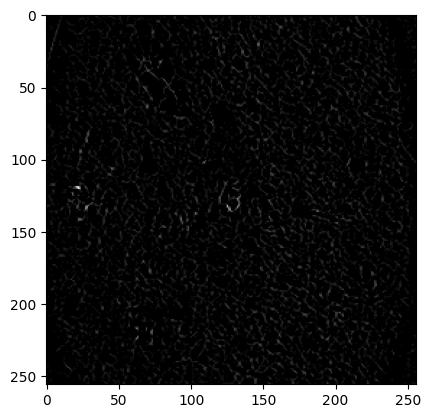

In [294]:
resize_img = resize_image(images[1])  
gray_img = gray_scaling(resize_img)  
citra_clahe = manual_clahe(gray_img, 5, (4, 4))
blurred = cv.GaussianBlur(gray_img, (3, 3), 0)
citra_sobel = sobel(blurred)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
top_hat = cv.morphologyEx(blurred, cv.MORPH_TOPHAT, kernel)



normalizeData = normalize(top_hat)

plt.imshow(normalizeData, cmap="gray")

In [295]:
dataPreprocessed = []
for i in range(len(images)):  
    resize_img = resize_image(images[i])  
    gray_img = gray_scaling(resize_img)  
    blurred = cv.GaussianBlur(gray_img, (3, 3), 0)
    citra_sobel = sobel(blurred)
    citra_opening = opening(citra_sobel)
    normalizeData = normalize(citra_opening)  

    dataPreprocessed.append(normalizeData)

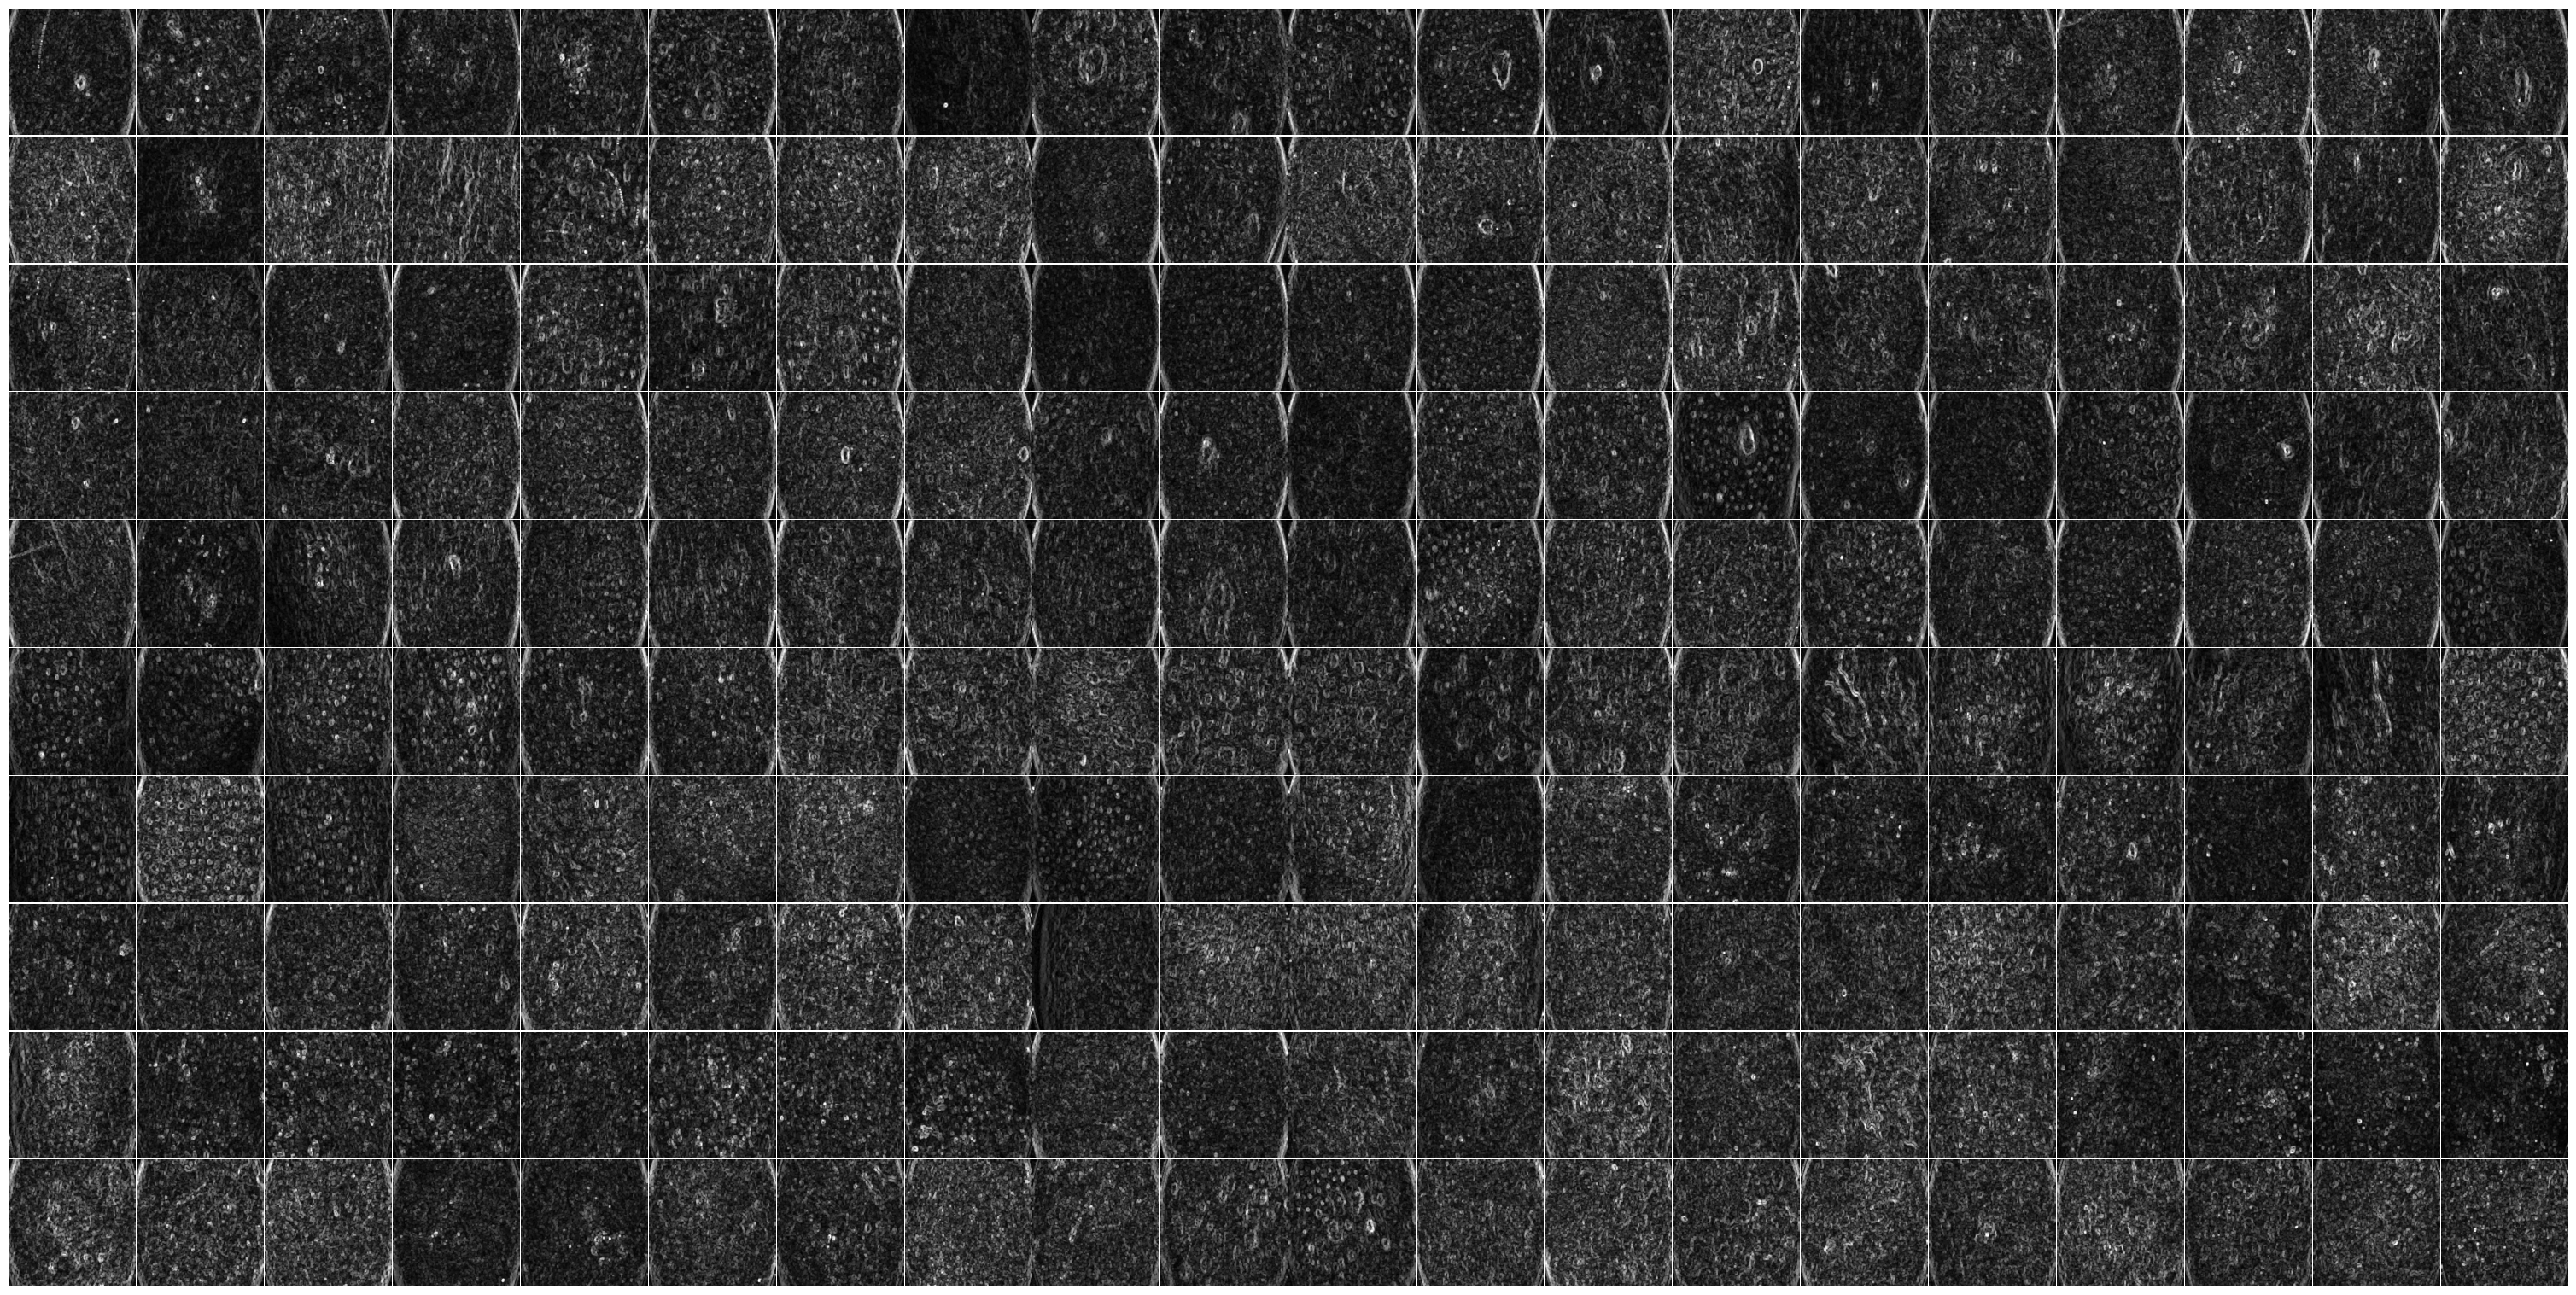

In [296]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = resize_image(dataPreprocessed[i])  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

In [297]:
for i in range(len(dataPreprocessed)):  
    dataPreprocessed[i] = (dataPreprocessed[i] / np.max(dataPreprocessed[i]) * 255).astype(np.uint8)  # Normalisasi ke uint8

<h1>Feature Extraction</h1>

In [298]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [299]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [300]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [301]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [302]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [303]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [304]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [305]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [306]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [307]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [308]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [309]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [310]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [311]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [312]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [313]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [314]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [315]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


In [316]:
print(df.describe())  # Lihat ringkasan statistik fitur

        Contrast0  Contrast45  Contrast90  Contrast135  Homogeneity0  \
count  200.000000  200.000000  200.000000   200.000000    200.000000   
mean   328.552012  441.602874  204.867178   444.309952      0.514905   
std    122.875874  164.204842   80.251005   165.415897      0.015111   
min     90.484911  120.000953   54.621063   123.658839      0.474075   
25%    234.217134  323.882537  147.712044   318.734364      0.505105   
50%    309.669968  413.653979  190.741108   422.818531      0.513964   
75%    394.629722  530.738466  248.576023   538.742030      0.526315   
max    714.469761  895.125552  435.787393   946.661576      0.555253   

       Homogeneity45  Homogeneity90  Homogeneity135  Dissimilarity0  \
count     200.000000     200.000000      200.000000      200.000000   
mean        0.316683       0.514663        0.316809        9.528857   
std         0.020375       0.019215        0.020366        1.931943   
min         0.270027       0.464860        0.269824        4.966958

<h1>CSV</h1>

In [317]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_3.csv')
hasilEkstrak

Filename          Label   Contrast0  Contrast45  Contrast90  \
0    101_5.jpg  Acne Vulgaris  228.587224  325.577147  152.833578   
1    102_2.jpg  Acne Vulgaris  275.740242  373.036940  200.062286   
2    103_2.jpg  Acne Vulgaris  254.475674  374.583376  194.488128   
3    106_1.jpg  Acne Vulgaris  227.921063  305.392049  142.296645   
4    106_7.jpg  Acne Vulgaris  300.793796  402.572042  166.662515   
..         ...            ...         ...         ...         ...   
195  118_2.jpg        Rosacea  346.775184  470.614441  226.604350   
196  118_3.jpg        Rosacea  577.133961  752.621745  347.593658   
197  118_4.jpg        Rosacea  345.965135  487.146790  230.455668   
198  119_1.jpg        Rosacea  360.472978  531.285075  272.699877   
199  119_2.jpg        Rosacea  416.671860  605.560615  307.976363   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     307.859731      0.543748       0.358114       0.554685        0.358827   
1     410.796463      0.495570       0.298627       0.503875        0.300184   
2     375.480846      0.530795       0.333496       0.528762        0.336283   
3     309.064145      0.518936       0.323364       0.520938        0.323049   
4     380.120938      0.503463       0.302707       0.503160        0.302962   
..           ...           ...            ...            ...             ...   
195   476.872680      0.515851       0.314531       0.511962        0.316552   
196   775.335179      0.495733       0.286429       0.485224        0.285815   
197   465.913033      0.509527       0.309808       0.508356        0.310588   
198   491.873172      0.506600       0.297721       0.494032        0.297023   
199   592.881092      0.518193       0.309404       0.508457        0.311610   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.031956  0.017918  0.175661  0.133341  0.178763   0.133859   
1    ...  0.013826  0.006414  0.114927  0.080080  0.117584   0.080087   
2    ...  0.021772  0.011490  0.147124  0.106428  0.147553   0.107192   
3    ...  0.018599  0.009329  0.134655  0.096576  0.136378   0.096589   
4    ...  0.015131  0.007178  0.121240  0.084573  0.123009   0.084725   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.019998  0.010220  0.141218  0.100847  0.141416   0.101095   
196  ...  0.013152  0.006020  0.115404  0.077933  0.114684   0.077588   
197  ...  0.018522  0.009224  0.134919  0.095638  0.136097   0.096043   
198  ...  0.014356  0.006840  0.121937  0.082376  0.119816   0.082705   
199  ...  0.015897  0.007534  0.126923  0.086273  0.126082   0.086801   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.869032       0.813422       0.913104        0.823577  
1        0.842748       0.787426       0.886243        0.765910  
2        0.813886       0.726168       0.858115        0.725511  
3        0.819477       0.758045       0.888932        0.755135  
4        0.800980       0.733712       0.890083        0.748563  
..            ...            ...            ...             ...  
195      0.789757       0.714668       0.863007        0.710872  
196      0.760669       0.687990       0.856092        0.678573  
197      0.775694       0.683776       0.850505        0.697551  
198      0.771802       0.663326       0.827322        0.688299  
199      0.755251       0.644410       0.819399        0.651849  

[200 rows x 30 columns]

<Axes: >

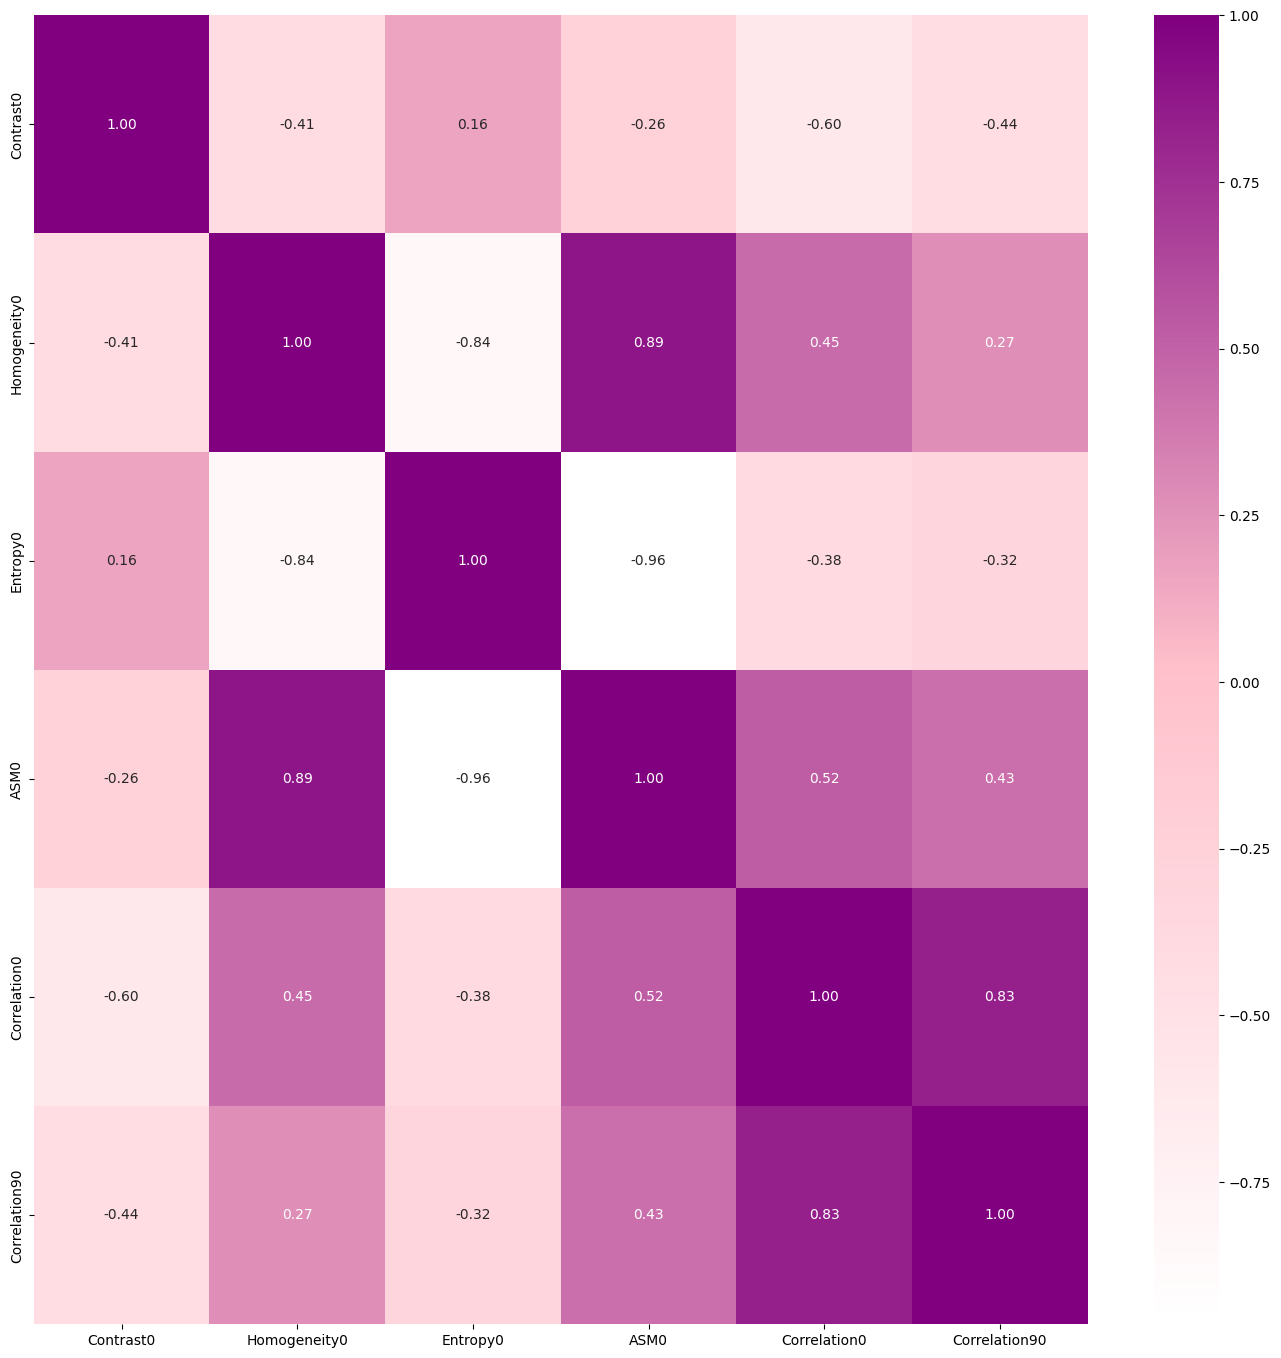

In [318]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [319]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(140, 6)
(60, 6)


In [320]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [321]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=12, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Nilai n-estimators diubah dari 5 ke 12, karena kalo pake 5 jadinya overfitting dengan gap 17. 12 juga masi overfitting, tapi gapnya lebih kecil (9).
Kalau n\_estimators kurang dari 12, model Random Forest belum cukup kompleks untuk menangkap pola data dengan baik, sehingga training accuracy masih agak rendah dan gap overfitting jadi besar karena model kurang fit; saat n\_estimators mencapai 12, model mulai cukup kompleks untuk belajar pola tanpa terlalu menghafal, menghasilkan gap overfitting yang lebih kecil dan performa yang lebih seimbang; namun jika n\_estimators lebih dari 13, model jadi sangat kompleks dan cenderung menghafal data training secara sempurna (training accuracy 1.0), sehingga overfitting meningkat karena model kehilangan kemampuan generalisasi meskipun akurasi testing tidak membaik.

In [322]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.96      1.00      0.98        69
      Rosacea       1.00      0.96      0.98        71

     accuracy                           0.98       140
    macro avg       0.98      0.98      0.98       140
 weighted avg       0.98      0.98      0.98       140

[[69  0]
 [ 3 68]]
Accuracy: 0.9785714285714285

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.85      0.94      0.89        31
      Rosacea       0.92      0.83      0.87        29

     accuracy                           0.88        60
    macro avg       0.89      0.88      0.88        60
 weighted avg       0.89      0.88      0.88        60

[[29  2]
 [ 5 24]]
Accuracy: 0.8833333333333333


In [323]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.77      0.74      0.76        69
      Rosacea       0.76      0.79      0.77        71

     accuracy                           0.76       140
    macro avg       0.76      0.76      0.76       140
 weighted avg       0.76      0.76      0.76       140

[[51 18]
 [15 56]]
Accuracy: 0.7642857142857142

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.93      0.84      0.88        31
      Rosacea       0.84      0.93      0.89        29

     accuracy                           0.88        60
    macro avg       0.89      0.88      0.88        60
 weighted avg       0.89      0.88      0.88        60

[[26  5]
 [ 2 27]]
Accuracy: 0.8833333333333333


In [324]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.82      0.81      0.82        69
      Rosacea       0.82      0.83      0.83        71

     accuracy                           0.82       140
    macro avg       0.82      0.82      0.82       140
 weighted avg       0.82      0.82      0.82       140

[[56 13]
 [12 59]]
Accuracy: 0.8214285714285714

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.74      0.94      0.83        31
      Rosacea       0.90      0.66      0.76        29

     accuracy                           0.80        60
    macro avg       0.82      0.80      0.79        60
 weighted avg       0.82      0.80      0.80        60

[[29  2]
 [10 19]]
Accuracy: 0.8


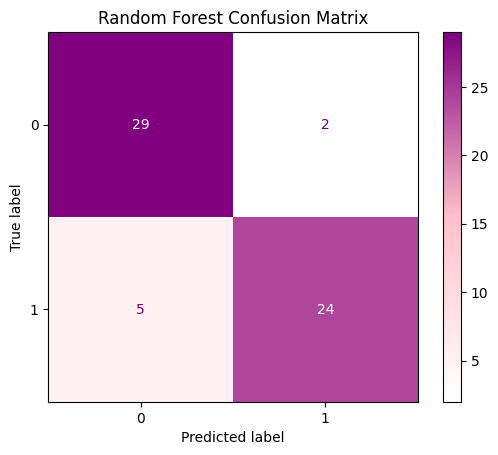

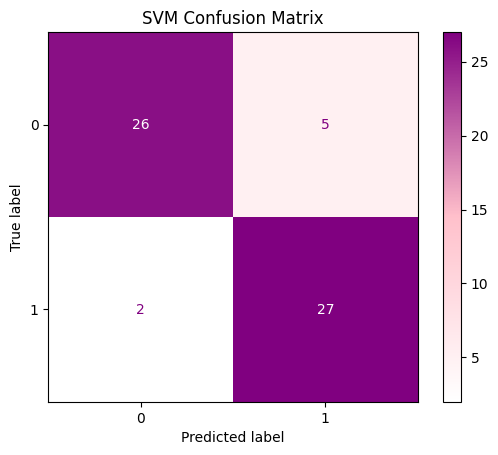

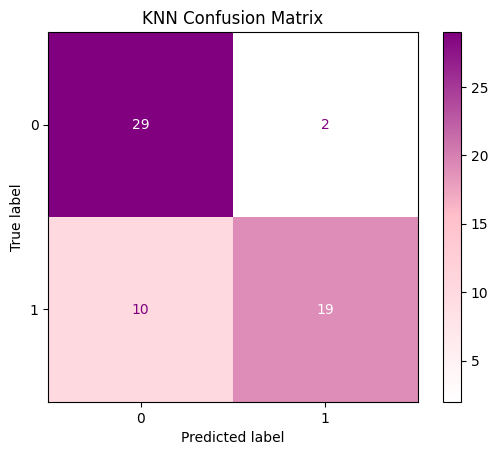

In [325]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")